## A/B - тестирование


Внутри увидите пример как формируются результаты по аб-тестированию. Прочтите сначала его, затем приступайте к выполнению задания.

В папке присутствует файл ab_test_ensembles.csv , который содержит реальные данные ab теста, когда-то проходившего у меня. Вам необходимо провести стандартный пайплайн, начав с ознакомления данных до вывода отчета. Условие гипотезы такое же как и в примере, нам необходимо нашим новым вариантом увеличить коэффициент конверсии на 2%, коэффициенты конверсии одинаковы с файлом из примера (плюс/минус) поэтому с этим проблем быть не должно. Условия гипотез теже.

В A/B тесте было два варианта работы сервиса - standard и svm_ensemble_v_1_22, где работала модель классификации пользователей.

Ответьте на 2 вопроса:

1. Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)
2. Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

Также необходимо провести небольшое EDA по представленному датасету, нарисовать два графика на ваш вкус.

---

**Баллы могут быть снижены** за качество кода - старайтесь чтобы код был максимально лаконичным. Названия переменных (если они используются) должны отражать максимальную ее сущность.

**Комментарии по сдаче практического задания**:
1. Залить в репу на github в папку module_2/ab_test_inference
2. Ссылку на репо отправлять мне на почту alexadevv@gmail.com не позднее дедлайна.
3. Тема письма: Домашнее задание по модулю 2 <Фамилия Имя>
4. После дедлайна, неотправленные на почту задания, оцениваются максимум в 7 баллов.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [2]:
df = pd.read_csv('ab_test_ensembles.csv')

In [3]:
df.head(3)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


<font color=darkgreen>
    Нет пропущенных значений.
<font/>

In [5]:
#Убедимся, что каждый user_id уникален
len(df.user_id.unique()) == df.shape[0]

True

<font color=darkgreen>
    Дубликаты пользователей отсутствуют.
<font/>

In [6]:
def cross_tab(data):
    return pd.crosstab(data['group'], data['variants'])

In [7]:
#Проверим, что данные корректно распределены по группам control
#и treatment, и что столбец 'variants' 
#соответствует назначенной версии сайта.
cross_tab(df)

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


In [8]:
def clean_data(data):
    data = data.drop(data[(data.variants == "svm_ensemble_v_1_22") & (data.group == "control")].index)
    data = data.drop(data[(data.variants == "standard") & (data.group == "treatment")].index)
    return data

In [9]:
df = clean_data(df)

In [10]:
cross_tab(df)

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,0
treatment,0,145311


In [11]:
df.nunique(), df.shape[0]

(user_id      290585
 timestamp    290585
 group             2
 variants          2
 converted         2
 location          1
 age_group         6
 user_type         2
 dtype: int64,
 290585)

<font color=darkgreen>
Для проведения A/B тестирования нам необходимо 2 группы:
Контрольная (control) группа A - группа пользователей, которым будет показываться старая версия сайта (standard).
Эксперементальная (treatment) группа B - группа пользователей, которым будет показываться новая версия сайта (svm_ensemble_v_1_22).
<font/>

In [12]:
# Разделение данных на группы
group_A = df[(df['group'] == 'control') & (df['variants'] == 'standard')]
group_B = df[(df['group'] == 'treatment') & (df['variants'] == 'svm_ensemble_v_1_22')]

# Проверка количества пользователей в каждой группе
print("Количество пользователей в группе A (control):", len(group_A))
print("Количество пользователей в группе B (treatment):", len(group_B))

Количество пользователей в группе A (control): 145274
Количество пользователей в группе B (treatment): 145311


<font color=darkgreen>
Равное разделение участников между группами в A/B тестировании помогает обеспечить максимальную статистическую мощность, уменьшает дисперсию, упрощает анализ и делает результаты более надежными и интерпретируемыми.
<font/>

In [13]:
group_B = group_B[:len(group_A)]

In [14]:
# Сформируем общую выборку
ab_df = pd.concat([group_A, group_B], axis=0)
ab_df.reset_index(drop=True, inplace=True)
ab_df.head(3)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user


In [15]:
ab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290548 entries, 0 to 290547
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290548 non-null  object
 1   timestamp  290548 non-null  object
 2   group      290548 non-null  object
 3   variants   290548 non-null  object
 4   converted  290548 non-null  int64 
 5   location   290548 non-null  object
 6   age_group  290548 non-null  object
 7   user_type  290548 non-null  object
dtypes: int64(1), object(7)
memory usage: 17.7+ MB


In [16]:
ab_df.group.value_counts(normalize=True)

group
control      0.5
treatment    0.5
Name: proportion, dtype: float64

In [17]:
def conversion_rates(data):
    conversion_rates = data.groupby('group')['converted']

    # Стандартное отклонение для сформированной выборки
    std_proportion = lambda x: np.std(x, ddof=0)
    # Стандартная ошибка для сформированной выборки
    se_proportion = lambda x: stats.sem(x, ddof=0)

    conversion_rates = conversion_rates.agg(['mean', std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
    return conversion_rates

In [18]:
conversion_rates(ab_df)

,CR mean,CR std,CR se
group,,,
control,0.120386,0.325413,0.000854
treatment,0.118831,0.323589,0.000849


In [19]:
def hist_gr(data):
    plt.figure(figsize=(4,6));
    ax = sns.barplot(x=data['group'], y=data['converted'], errorbar=('ci', False));
    for i in ax.containers:
        ax.bar_label(i,)
    plt.ylim(0, 0.17);
    plt.title('Conversion rate by experimental samples', pad=20)
    plt.xlabel('Group', labelpad=15);
    plt.ylabel('Converted (proportion)', labelpad=15);

<font color=darkgreen>
На основе этих данных можно предположить, что новая версия сайта (группа treatment) не оказывает значительного влияния на коэффициент конверсии по сравнению с контрольной версией (группа control). Для окончательных выводов проведем  Z-тест, чтобы проверить значимость разницы.
<br>Если результат статистического теста покажет p-value выше уровня значимости (0.05), то можно с уверенностью утверждать, что разница незначима.
<font/>

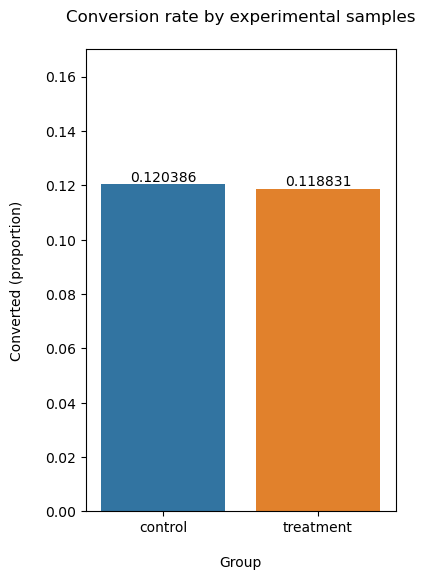

In [20]:
hist_gr(ab_df)

<font color=darkgreen>
H0 : p = p0 
<br>H : p != p0,
<br>где p и p0 означают коэффициенты конверсии между новым и старым вариантами соответственно. 
<br>Уровень доверия в 95%.
<br>alfa = 0.05.
<font/>

In [20]:
def get_statistics(data):
    control_results = data[data['group'] == 'control']['converted']
    treatment_results = data[data['group'] == 'treatment']['converted']

    n_con = control_results.count()
    n_treat = treatment_results.count()
    successes = [control_results.sum(), treatment_results.sum()]
    nobs = [n_con, n_treat]

    z_stat, pval = proportions_ztest(successes, nobs=nobs)
    (lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

    print(f'Z-statistic: {z_stat:.2f}')
    print(f'p-value: {pval:.3f}')
    print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
    print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

In [21]:
get_statistics(ab_df)

Z-statistic: 1.29
p-value: 0.196
CI 95% for control group: [0.119, 0.122]
CI 95% for treatment group: [0.117, 0.120]


<font color=darkgreen>
    <b>Для всех пользователей</b>
<br>Значение Z-статистики составляет 1.29, что ниже критического значения 1.96 для уровня значимости alpha = 0.05. Это означает, что разница между группами не достигает уровня значимости для отклонения нулевой гипотезы.
<br>P-value = 0.196, что значительно выше уровня значимости alpha = 0.05. Это указывает на то, что разница между коэффициентами конверсии в контрольной и экспериментальной группах не является статистически значимой.
<br>Доверительные интервалы для двух групп перекрываются, что также указывает на отсутствие значительной разницы между ними.
<br>Не можем отклонить нулевую гипотезу H0, что означает наш сайт никак статистически значимо не влияет на уровень конверсии и повышение уровня конверсии - это случайность.
<font/>

2.Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

In [22]:
#Посмотрим какие типы пользователей есть
df = pd.read_csv('ab_test_ensembles.csv')
df.user_type.unique()

array(['registered_user', 'new_user'], dtype=object)

user_type
new_user           Axes(0.125,0.11;0.775x0.77)
registered_user    Axes(0.125,0.11;0.775x0.77)
Name: variants, dtype: object

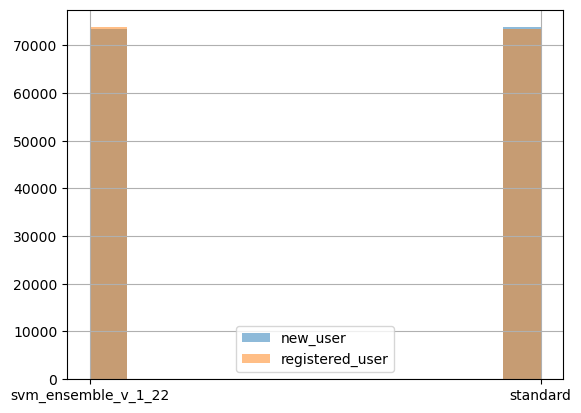

In [23]:
df.groupby('user_type').variants.hist(legend=True, alpha=0.5, bins=12)

In [24]:
#Cформируем датасеты дляя старых и новых пользователей
df_new = df[df.user_type == 'new_user']
df_reg = df[df.user_type == 'registered_user']

In [25]:
df_new = clean_data(df_new)
cross_tab(df_new)

variants,standard,svm_ensemble_v_1_22
group,,
control,72791,0
treatment,0,72482


In [26]:
def ab_data(data):
    # Разделение данных на группы
    group_A = data[(data['group'] == 'control') & (data['variants'] == 'standard')]
    group_B = data[(data['group'] == 'treatment') & (data['variants'] == 'svm_ensemble_v_1_22')]
    #Формируем одинаковый размер
    count = min(len(group_A), len(group_B))
    group_A = group_A[:count]
    group_B = group_B[:count]
    # Формируем общую выборку
    ab_df = pd.concat([group_A, group_B], axis=0)
    ab_df.reset_index(drop=True, inplace=True)
    return ab_df

In [27]:
#Выборка для АВ теста среди новых пользователей
ab_df_new = ab_data(df_new)

In [28]:
ab_df_new.group.value_counts(normalize=True)

group
control      0.5
treatment    0.5
Name: proportion, dtype: float64

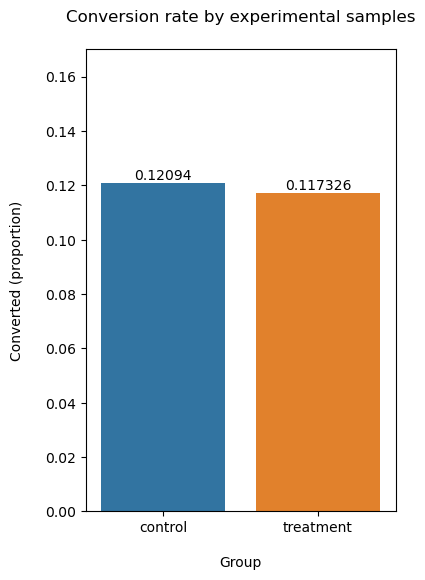

In [29]:
hist_gr(ab_df_new)

In [30]:
conversion_rates(ab_df_new)

,CR mean,CR std,CR se
group,,,
control,0.120940,0.326058,0.001211
treatment,0.117326,0.321808,0.001195


<font color=darkgreen>
    На основе этих данных новая версия сайта (treatment) имеет немного более низкий средний коэффициент конверсии по сравнению с контрольной группой (control). Однако разница достаточно мала, чтобы говорить о её статистической значимости.
    <font/>

In [31]:
get_statistics(ab_df_new)

Z-statistic: 2.12
p-value: 0.034
CI 95% for control group: [0.119, 0.123]
CI 95% for treatment group: [0.115, 0.120]


<font color=darkgreen>
<b>Для новых пользователей</b>
<br>Z-статистика: 2.12 указывает на то, что разница между средними значениями коэффициентов конверсии в группах контрольной и экспериментальной статистически значима.
<br>p-value: 0.034, что меньше уровня значимости 0.05. Это означает, что с вероятностью 95% можно отвергнуть нулевую гипотезу о том, что коэффициенты конверсии в обеих группах равны.
<br>Доверительные интервалы двух групп не перекрываются, что дополнительно указывает на наличие разницы между их средними значениями коэффициентов конверсии.
<br>Mожно утверждать,что версия сайта, используемая в группе treatment, статистически значимо отличается по коэффициенту конверсии от версии, используемой в группе control. Это означает, что новая версия сайта оказывает влияние на поведение пользователей.
<font/>

In [32]:
df_reg = clean_data(df_reg)
cross_tab(df_reg)

variants,standard,svm_ensemble_v_1_22
group,,
control,72483,0
treatment,0,72829


In [33]:
#Выборка для АВ теста среди старых пользователей
ab_df_reg = ab_data(df_reg)
ab_df_reg.group.value_counts(normalize=True)

group
control      0.5
treatment    0.5
Name: proportion, dtype: float64

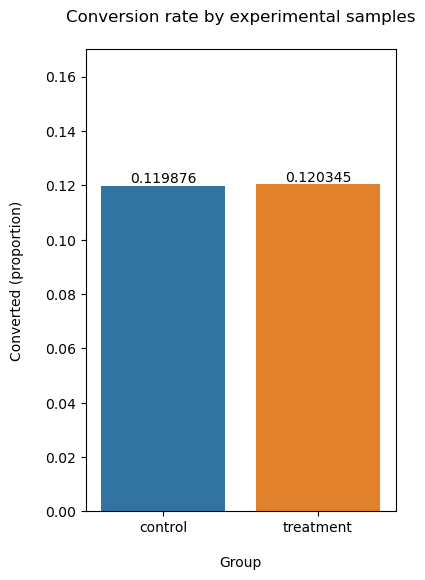

In [34]:
hist_gr(ab_df_reg)

In [35]:
conversion_rates(ab_df_reg)

,CR mean,CR std,CR se
group,,,
control,0.119876,0.324817,0.001206
treatment,0.120345,0.325365,0.001209


<font color=darkgreen>
    Разница в средних значениях коэффициентов конверсии между контрольной и экспериментальной группами незначительна. Схожие значения стандартного отклонения и стандартной ошибки указывают на сопоставимую изменчивость и точность данных в обеих группах. 
    <font/>

In [36]:
get_statistics(ab_df_reg)

Z-statistic: -0.27
p-value: 0.784
CI 95% for control group: [0.118, 0.122]
CI 95% for treatment group: [0.118, 0.123]


<font color=darkgreen>
<b>Для старых пользователей</b>
<br>Z-статистика: 2.12 -0.27 указывает на отсутствие значительной разницы между средними значениями коэффициентов конверсии в контрольной и экспериментальной группах.
<br>p-value:  0.784 значительно превышает уровень значимости 0.05. Это означает, что мы не можем отвергнуть нулевую гипотезу.
<br>Доверительные интервалы обеих групп частично перекрываются, что подтверждает вывод о том, что нет значительной разницы между ними.
<br>Новая версия сайта (группа treatment) не показывает значимого улучшения по сравнению с контрольной версией (группа control).
<font/>